## Transformers-LSTM-GRU

### Import Libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, Conv1D, MaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [2]:
# Load the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)

train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [3]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'&\w+;', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Combine 'Title' and 'Description' into 'clean_text' and preprocess
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert text to sequences
X_train_title_seq = tokenizer.texts_to_sequences(train_df['Title'])
X_test_title_seq = tokenizer.texts_to_sequences(test_df['Title'])

X_train_description_seq = tokenizer.texts_to_sequences(train_df['Description'])
X_test_description_seq = tokenizer.texts_to_sequences(test_df['Description'])

# Determine max sequence length and pad sequences
max_length_titles = max([len(x) for x in X_train_title_seq])
max_length_descriptions = max([len(x) for x in X_train_description_seq])

X_train_title_pad = pad_sequences(X_train_title_seq, maxlen=max_length_titles)
X_test_title_pad = pad_sequences(X_test_title_seq, maxlen=max_length_titles)

X_train_description_pad = pad_sequences(X_train_description_seq, maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(X_test_description_seq, maxlen=max_length_descriptions)

y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

# Download and load GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

--2024-10-29 15:49:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-29 15:49:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-29 15:49:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### Basic training module (Base Model)

In [4]:
# Define inputs and embedding layers
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)(title_input)
title_gru = GRU(128, return_sequences=True)(title_embedding)
title_lstm = LSTM(128, return_sequences=False)(title_gru)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)(description_input)
description_gru = GRU(128, return_sequences=True)(description_embedding)
description_lstm = LSTM(128, return_sequences=False)(description_gru)

merged = Concatenate()([title_lstm, description_lstm])

# Fully connected layers after merging
dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

# Build and compile model
model = Model(inputs=[title_input, description_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training with early stopping
model.fit([X_train_title_pad, X_train_description_pad], y_train,
          validation_split=0.1, epochs=5, batch_size=32, verbose=1,
          callbacks=[early_stopping])

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8677 - loss: 0.3874 - val_accuracy: 0.8954 - val_loss: 0.2963
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9049 - loss: 0.2725 - val_accuracy: 0.9045 - val_loss: 0.2698
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.9198 - loss: 0.2265 - val_accuracy: 0.8923 - val_loss: 0.2968
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9334 - loss: 0.1867 - val_accuracy: 0.9072 - val_loss: 0.2786
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.9444 - loss: 0.1530 - val_accuracy: 0.8977 - val_loss: 0.3205


### Testing module 1 (Base Model)

238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Base Model Accuracy: 0.9003947368421052
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1900
           1       0.96      0.95      0.96      1900
           2       0.85      0.87      0.86      1900
           3       0.88      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



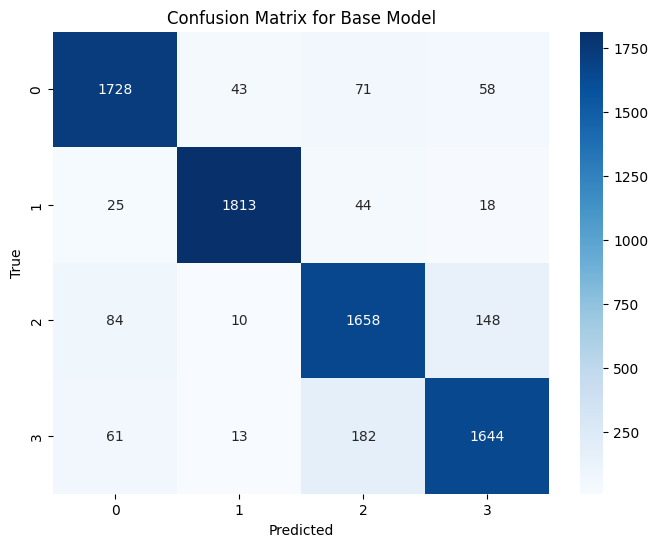

In [5]:
# Predictions and metrics for base model
y_pred_base = model.predict([X_test_title_pad, X_test_description_pad]).argmax(axis=1)
print("Base Model Accuracy:", np.mean(y_pred_base == y_test))
print(classification_report(y_test, y_pred_base))
conf_matrix_base = confusion_matrix(y_test, y_pred_base)

# Display confusion matrix for base model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Base Model')
plt.show()

### Hyperparameter selection module

In [6]:
def model_builder(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    gru_units = trial.suggest_int('gru_units', 64, 256)
    lstm_units = trial.suggest_int('lstm_units', 64, 256)

    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = Embedding(input_dim=5000, output_dim=100,
                                weights=[embedding_matrix], trainable=False)(title_input)
    title_gru = GRU(gru_units, return_sequences=True)(title_embedding)
    title_lstm = LSTM(lstm_units, return_sequences=False)(title_gru)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = Embedding(input_dim=5000, output_dim=100,
                                      weights=[embedding_matrix], trainable=False)(description_input)
    description_gru = GRU(gru_units, return_sequences=True)(description_embedding)
    description_lstm = LSTM(lstm_units, return_sequences=False)(description_gru)

    merged = Concatenate()([title_lstm, description_lstm])
    dense_1 = Dense(128, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Optuna objective function
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train,
              validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    loss, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best trial:", study.best_trial)

[I 2024-10-29 15:56:11,756] A new study created in memory with name: no-name-1447acd6-93a4-4021-a2da-4b0b7ccbe65e


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8652 - loss: 0.3842 - val_accuracy: 0.8942 - val_loss: 0.2815
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9075 - loss: 0.2685 - val_accuracy: 0.9006 - val_loss: 0.2806
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9212 - loss: 0.2244 - val_accuracy: 0.9025 - val_loss: 0.2746
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9069 - loss: 0.2780


[I 2024-10-29 15:58:17,839] Trial 0 finished with value: 0.9043421149253845 and parameters: {'dropout_rate': 0.009126852035705457, 'learning_rate': 0.0012905643573711038, 'gru_units': 105, 'lstm_units': 186}. Best is trial 0 with value: 0.9043421149253845.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8650 - loss: 0.3924 - val_accuracy: 0.8901 - val_loss: 0.2974
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9034 - loss: 0.2788 - val_accuracy: 0.9010 - val_loss: 0.2773
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9162 - loss: 0.2410 - val_accuracy: 0.9031 - val_loss: 0.2710
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9038 - loss: 0.2670


[I 2024-10-29 16:00:24,978] Trial 1 finished with value: 0.9057894945144653 and parameters: {'dropout_rate': 0.2727229536499983, 'learning_rate': 0.0009618974515889911, 'gru_units': 85, 'lstm_units': 214}. Best is trial 1 with value: 0.9057894945144653.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8194 - loss: 0.5479 - val_accuracy: 0.8813 - val_loss: 0.3307
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8823 - loss: 0.3397 - val_accuracy: 0.8838 - val_loss: 0.3175
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8870 - loss: 0.3238 - val_accuracy: 0.8842 - val_loss: 0.3140
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8851 - loss: 0.3247


[I 2024-10-29 16:02:32,999] Trial 2 finished with value: 0.8897368311882019 and parameters: {'dropout_rate': 0.19421416252856777, 'learning_rate': 5.096193370304954e-05, 'gru_units': 199, 'lstm_units': 98}. Best is trial 1 with value: 0.9057894945144653.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.8620 - loss: 0.4086 - val_accuracy: 0.8822 - val_loss: 0.3266
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.8921 - loss: 0.3213 - val_accuracy: 0.8695 - val_loss: 0.3765
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.8891 - loss: 0.3304 - val_accuracy: 0.8809 - val_loss: 0.3222
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8829 - loss: 0.3486


[I 2024-10-29 16:04:37,690] Trial 3 finished with value: 0.8860526084899902 and parameters: {'dropout_rate': 0.12422587197374091, 'learning_rate': 0.006535468796071264, 'gru_units': 138, 'lstm_units': 66}. Best is trial 1 with value: 0.9057894945144653.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.8615 - loss: 0.4108 - val_accuracy: 0.8877 - val_loss: 0.3041
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.8963 - loss: 0.3057 - val_accuracy: 0.8895 - val_loss: 0.3086
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9003 - loss: 0.2927 - val_accuracy: 0.8840 - val_loss: 0.3216
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8868 - loss: 0.3333


[I 2024-10-29 16:06:41,571] Trial 4 finished with value: 0.8882894515991211 and parameters: {'dropout_rate': 0.23215753124579164, 'learning_rate': 0.006373998816698033, 'gru_units': 89, 'lstm_units': 139}. Best is trial 1 with value: 0.9057894945144653.


Best trial: FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.9057894945144653], datetime_start=datetime.datetime(2024, 10, 29, 15, 58, 17, 840318), datetime_complete=datetime.datetime(2024, 10, 29, 16, 0, 24, 978361), params={'dropout_rate': 0.2727229536499983, 'learning_rate': 0.0009618974515889911, 'gru_units': 85, 'lstm_units': 214}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'gru_units': IntDistribution(high=256, log=False, low=64, step=1), 'lstm_units': IntDistribution(high=256, log=False, low=64, step=1)}, trial_id=1, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.8645 - loss: 0.3947 - val_accuracy: 0.8915 - val_loss: 0.2894
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9032 - loss: 0.2810 - val_accuracy: 0.9003 - val_loss: 0.2817
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9174 - loss: 0.2376 - val_accuracy: 0.8984 - val_loss: 0.2775
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9267 - loss: 0.2057 - val_accuracy: 0.9040 - val_loss: 0.2776
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9387 - loss: 0.1739 - val_accuracy: 0.8989 - val_loss: 0.3178
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Optimized Model Accuracy: 0.9055263157894737
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      1900
           1       0.97      0.95      0.96      1900
           2       0.87      0.87      0.87      1900
           3       0.85      0.92      0.8

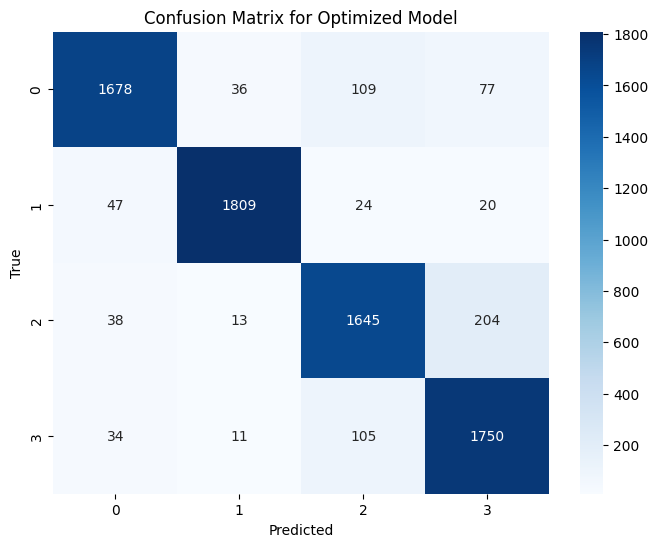

In [7]:
# Build optimized model with best parameters
best_trial = study.best_trial
model_optimized = model_builder(best_trial)

# Training and testing optimized model
model_optimized.fit([X_train_title_pad, X_train_description_pad], y_train,
                    validation_split=0.1, epochs=5, batch_size=32, verbose=1)
y_pred_optimized = model_optimized.predict([X_test_title_pad, X_test_description_pad]).argmax(axis=1)

# Optimized model metrics
print("Optimized Model Accuracy:", np.mean(y_pred_optimized == y_test))
print(classification_report(y_test, y_pred_optimized))
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

# Display confusion matrix for optimized model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Optimized Model')
plt.show()